# Hourly PSDS - FFBI & ROMY

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from functions.get_fband_average import __get_fband_average

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}


config['d1'], config['d2'] = "2023-09-23", "2023-12-31"

config['path_to_data'] = data_path+f"LNM2/PSDS/"

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['frequency_limits'] = 1e-3, 1e1


## Methods

In [4]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [5]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [6]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [7]:
def __replace_noisy_psds_with_nan(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan, nanmean, array

    idx_min = 0
    idx_max = arr.shape[1]-1

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim[0]:
                if n == 0:
                    idx_min = 0
                else:
                    idx_min = n-1
                break
        for n, f in enumerate(ff):
            if f > flim[1]:
                idx_max = n
                break

    l1 = shape(arr)[0]

    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if ff is not None:
            if nanmean(arr[ii, idx_min:idx_max]) > threshold_mean:
                rejected.append(arr[ii, :])
                arr[ii, :] = ones(shape(arr)[1]) * nan


    l2 = len(rejected)

    print(f" -> removed {l1-l2} rows due to mean thresholds ({round(ff[idx_min],4)} and {round(ff[idx_max],4)} Hz)!")
    print(f" -> {l2} / {l1} psds removed")

    return arr, array(rejected)

In [8]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, names, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 5

    fig, axes = plt.subplots(NN, 1, figsize=(12, 12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            if show_rejected:
                for reject in rejected[j]:
                     axes[j].loglog(ff[j], reject, color='grey', alpha=0.6, zorder=2)
        except:
            pass

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[j].set_xlim(1e-3, 2e0)
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)


    axes[NN-1].set_xlabel("Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(d)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)
    axes[4].text(.01, .95, '(e)', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    sta, cha = names[0].split("_")[-2], names[0].split("_")[-1]
    axes[0].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)

    sta, cha = names[1].split("_")[-2], names[1].split("_")[-1]
    axes[1].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)

    sta, cha = names[2].split("_")[-2], names[2].split("_")[-1]
    axes[2].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)

    sta, cha = names[3].split("_")[-2], names[3].split("_")[-1]
    axes[3].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    sta, cha = names[4].split("_")[-2], names[4].split("_")[-1]
    axes[4].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-23, top=1e-17)
    axes[1].set_ylim(bottom=1e-23, top=1e-17)
    axes[2].set_ylim(bottom=1e-23, top=1e-17)
    axes[3].set_ylim(bottom=1e-6, top=1e6)
    axes[4].set_ylim(bottom=1e-6, top=1e6)

    axes[0].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[3].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)
    axes[4].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5, ticks=arange(1,N,2))


    plt.show();
    return fig

In [9]:
from functions.get_fband_averages import __get_fband_averages

## RUN for all files 

In [10]:
baro_lnm = read_csv(data_path+f"LNM2/data/"+"baro_nlnm_nhnm.csv")

baro_lnm['nlnm_baro'] = 10**(baro_lnm['nlnm_baro_db']/10)
baro_lnm['nhnm_baro'] = 10**(baro_lnm['nhnm_baro_db']/10)

 -> removed 24 rows due to mean thresholds (0.0 and 0.0501 Hz)!
 -> 0 / 24 psds removed
 -> removed 14 rows due to mean thresholds (0.0 and 0.0501 Hz)!
 -> 10 / 24 psds removed


/home/andbro/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> removed 15 rows due to mean thresholds (0.0 and 0.0501 Hz)!
 -> 9 / 24 psds removed


/home/andbro/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> removed 24 rows due to mean thresholds (0.0 and 4.9999 Hz)!
 -> 0 / 24 psds removed
 -> removed 24 rows due to mean thresholds (0.0 and 4.9999 Hz)!
 -> 0 / 24 psds removed


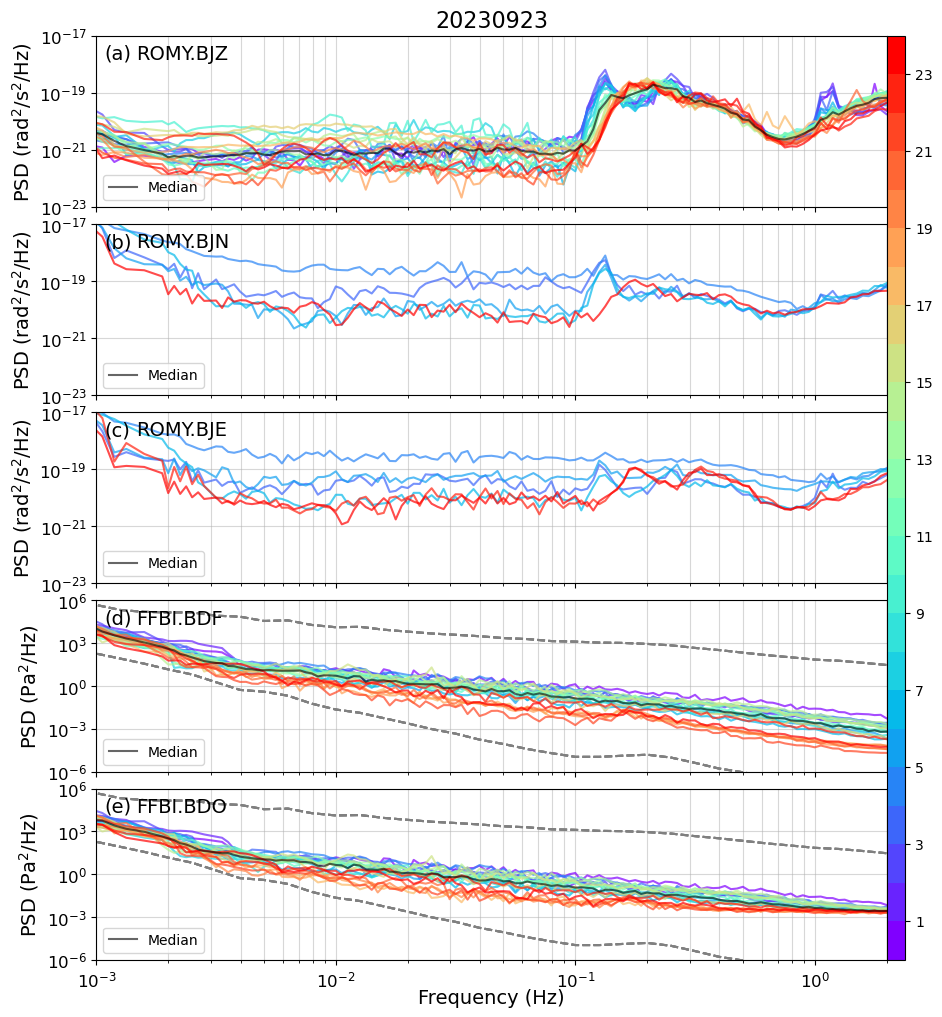

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230923.png
 -> removed 24 rows due to mean thresholds (0.0 and 0.0501 Hz)!
 -> 0 / 24 psds removed
 -> removed 20 rows due to mean thresholds (0.0 and 0.0501 Hz)!
 -> 4 / 24 psds removed


/home/andbro/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> removed 20 rows due to mean thresholds (0.0 and 0.0501 Hz)!
 -> 4 / 24 psds removed


/home/andbro/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> removed 24 rows due to mean thresholds (0.0 and 4.9999 Hz)!
 -> 0 / 24 psds removed
 -> removed 24 rows due to mean thresholds (0.0 and 4.9999 Hz)!
 -> 0 / 24 psds removed


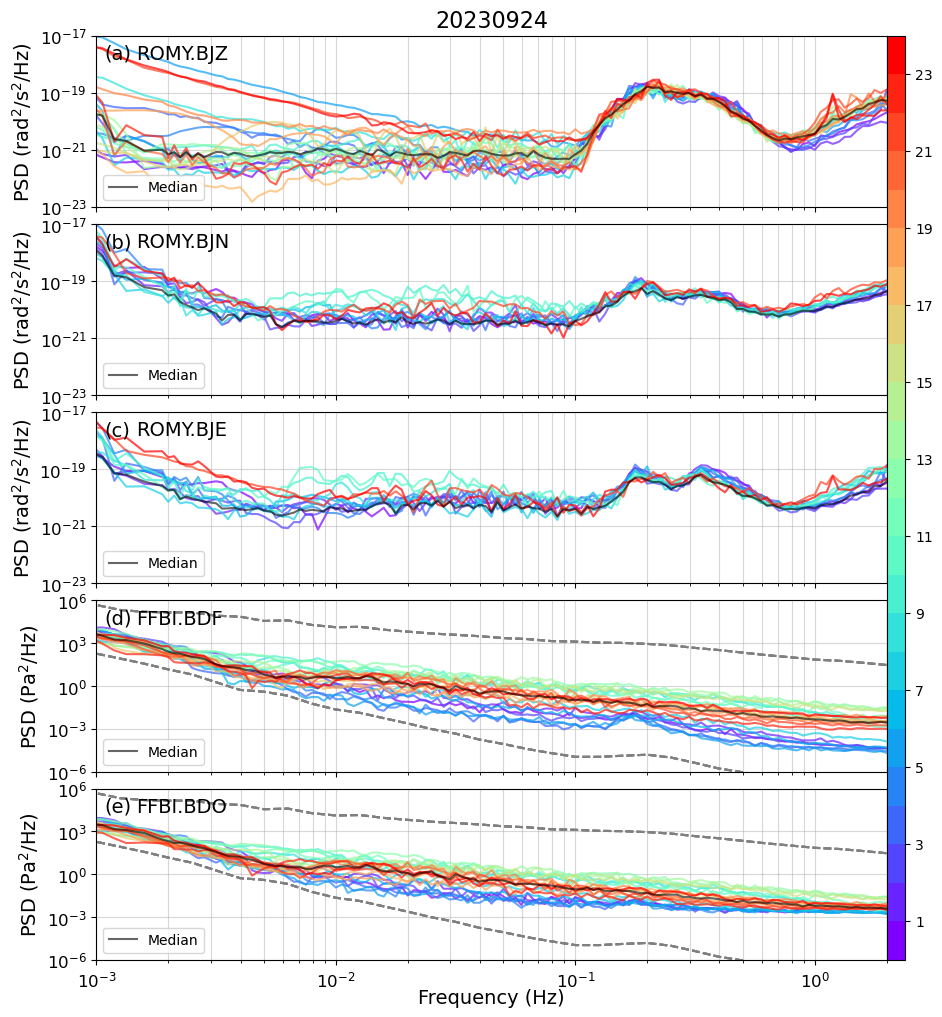

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230924.png


In [11]:

psds_medians_out, times_out = [], []

rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5 = [], [], [], [], []

for _i, day in enumerate(date_range(config['d1'], config['d2'])):

    day = str(day).split(" ")[0].replace("-", "")

    config['outpath_figname'] = "joint_"+day

    if _i > 1:
        continue

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {config['outpath_figname']} ...")
    #     continue


    try:


        ## Data1 --------------------------
        name1 = "ROMY/2023_ROMY_BJZ"

        out = read_pickle(config['path_to_data']+f"{name1}_3600_{day}_hourly.pkl")
        ff1, dat1 = out['frequencies'], out['psd']

        dat1, rejected_dat1 = __replace_noisy_psds_with_nan(dat1, threshold_mean=1e-18, ff=ff1, flim=[0, 0.05])
        # dat1, ff1 = __cut_frequencies_array(dat1, ff1, config['frequency_limits'][0], config['frequency_limits'][1])
        ff1, dat1 = __get_fband_averages(ff1, dat1)

        ## Data2 --------------------------
        name2 = "ROMY/2023_ROMY_BJN"

        out = read_pickle(config['path_to_data']+f"{name2}_3600_{day}_hourly.pkl")
        ff2, dat2 = out['frequencies'], out['psd']

        dat2, rejected_dat2 = __replace_noisy_psds_with_nan(dat2, threshold_mean=1e-18, ff=ff2, flim=[0, 0.05])
        # dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])
        ff2, dat2 = __get_fband_averages(ff2, dat2)


        ## Data3 --------------------------
        name3 = "ROMY/2023_ROMY_BJE"

        out = read_pickle(config['path_to_data']+f"{name3}_3600_{day}_hourly.pkl")
        ff3, dat3 = out['frequencies'], out['psd']

        dat3, rejected_dat3 = __replace_noisy_psds_with_nan(dat3, threshold_mean=1e-18, ff=ff3, flim=[0, 0.05])
        # dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])
        ff3, dat3 = __get_fband_averages(ff3, dat3)


        ## Data4 --------------------------
        name4 = "FFBI/2023_FFBI_BDF"

        out = read_pickle(config['path_to_data']+f"{name4}_3600_{day}_hourly.pkl")
        ff4, dat4 = out['frequencies'], out['psd']

        dat4, rejected_dat4 = __replace_noisy_psds_with_nan(dat4, threshold_mean=1e3, ff=ff4, flim=None)
        # dat4, ff4 = __cut_frequencies_array(dat4, ff4, config['frequency_limits'][0], config['frequency_limits'][1])
        ff4, dat4 = __get_fband_averages(ff4, dat4)


        ## Data5 --------------------------
        name5 = "FFBI/2023_FFBI_BDO"

        out = read_pickle(config['path_to_data']+f"{name5}_3600_{day}_hourly.pkl")
        ff5, dat5 = out['frequencies'], out['psd']

        dat5, rejected_dat5 = __replace_noisy_psds_with_nan(dat5, threshold_mean=1e4, ff=ff5, flim=None)
        # dat5, ff5 = __cut_frequencies_array(dat5, ff5, config['frequency_limits'][0], config['frequency_limits'][1])
        ff5, dat5 = __get_fband_averages(ff5, dat5)


    except Exception as e:
        print(" -> exception !")
        print(e)
        continue


    fig = __makeplot_colorlines_overview(config,
                                         [ff1, ff2, ff3, ff4, ff5],
                                         [dat1, dat2, dat3, dat4, dat5],
                                         [rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5],
                                         [name1, name2, name3, name4, name5],
                                         day,
                                         show_rejected=True)


    app = f"_{name1[-1]}{name2[-1]}{name3[-1]}"

    print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    fig.savefig(config['outpath_figures']+"joint_ROMY/"+config['outpath_figname']+f"_ROMY{app}.png", format="png", transparent=False, bbox_inches='tight', dpi=150)


In [12]:
os.system("""spd-say "Finished" """)

0